# Homework 4 - Group B 16

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

- Bryce Hopkins
- Nick Lewis
- Zak Mehdi

***

# Data

### Note
This homework continues with the data from `Homework 3`.

### Swaption Vol Data

The file `data/swaption_vol_data_2024-02-20.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swap rate** which you can calculate.

Your data: ywill use a single row of this data for the `1x4` swaption.
* date: `2024-02-20`
* expiration: 1yr
* tenor: 4yrs

As in `Homework 3`, you will need the forward swap value and the actual strikes being referred to in the provided data (which quotes relative strikes.)

In [85]:
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from scipy.optimize import fsolve

from scipy.stats import norm
from scipy.optimize import minimize

from pandas.tseries.offsets import Day, BDay
from datetime import date

import numpy.polynomial.polynomial as poly

from treasury_cmds import compound_rate


In [86]:
def ratecurve_to_discountcurve(ratecurve, n_compound=None):

    if isinstance(ratecurve,pd.DataFrame):
        ratecurve = ratecurve.iloc[:,0]
        
    if n_compound is None:
        discountcurve = np.exp(-ratecurve * ratecurve.index)
    else:
        discountcurve = 1 / (1+(ratecurve / n_compound))**(n_compound * ratecurve.index)

    return discountcurve  

def ratecurve_to_forwardcurve(ratecurve, n_compound=None, dt=None):
    if isinstance(ratecurve,pd.DataFrame):
        ratecurve = ratecurve.iloc[:,0]
        
    if dt is None:
        dt = ratecurve.index[1] - ratecurve.index[0]
        
    discountcurve = ratecurve_to_discountcurve(ratecurve, n_compound=n_compound)
    
    F = discountcurve / discountcurve.shift()
    
    if n_compound is None:
        display('TODO')
    else:
        forwardcurve = n_compound * (1/(F**(n_compound * dt)) - 1)
    
    return forwardcurve

def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

def interp_curves(data,dt=None, date=None, interp_method='linear',order=None, extrapolate=True):

    if dt is None:
        dt = data.columns[1] - data.columns[0]
    
    freq = 1/dt
    
    if date is None:
        temp = data
    else:
        temp = data.loc[date,:]

    newgrid = pd.DataFrame(dtype=float, index=np.arange(dt,temp.index[-1]+dt,dt),columns=['quotes'])
    # sofr curve last index often 10.02 command above extends to 10+. If barely overruns, toss last value
    overrun = (temp.index[-1] % dt)/dt
    if overrun>0 and overrun < .1:
        newgrid = newgrid.iloc[:-1,:]
        
    #newgrid.index = (freq*newgrid.index.values).round(0)/freq

    curves = temp.to_frame().rename(columns={temp.name:'quotes'})
    curves = pd.concat([curves,newgrid],axis=0)
    curves['interp'] = curves['quotes']

    if extrapolate:
        curves['interp'].interpolate(method=interp_method, order=order, limit_direction='both', fill_value = 'extrapolate',inplace=True)
    else:
        curves['interp'].interpolate(method=interp_method, order=order,inplace=True)
    
    curves = curves.loc[newgrid.index,:]
    curves = curves[~curves.index.duplicated()].sort_index()
    
    return curves

def plot_interp_curves(curves,plot_contin=True):
    fig, ax = plt.subplots()
    curves['quotes'].plot.line(ax=ax, linestyle='None',marker='*')
    curves.iloc[:,1:].plot.line(ax=ax, linestyle='--',marker='')
            
    plt.legend()
    plt.show()
 
def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        accr_frac = (T-round(T))*cpnfreq
    
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price


def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration


def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    pv_wrapper = lambda y: price - price_bond(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)
    ytm = fsolve(pv_wrapper,.01)
    return ytm


def calc_swaprate(discounts,T,freqswap):
    freqdisc = round(1/discounts.index.to_series().diff().mean())
    step = round(freqdisc / freqswap)
    
    periods_swap = discounts.index.get_loc(T)
    # get exclusive of left and inclusive of right by shifting both by 1
    periods_swap += 1

    swaprate = freqswap * (1 - discounts.loc[T])/discounts.iloc[step-1:periods_swap:step].sum()
    return swaprate


def calc_fwdswaprate(discounts, Tfwd, Tswap, freqswap):
    freqdisc = round(1/discounts.index.to_series().diff().mean())
    step = round(freqdisc / freqswap)
    
    periods_fwd = discounts.index.get_loc(Tfwd)
    periods_swap = discounts.index.get_loc(Tswap)
    # get exclusive of left and inclusive of right by shifting both by 1
    periods_fwd += step
    periods_swap += 1
    
    fwdswaprate = freqswap * (discounts.loc[Tfwd] - discounts.loc[Tswap]) / discounts.iloc[periods_fwd:periods_swap:step].sum()
    return fwdswaprate


def extract_fedpath(curves,feddates,spotfedrate):

    r0 = spotfedrate
    
    tag = [dt.strftime('%Y-%m') for dt in curves['last_tradeable_dt']]
    curves['date'] = tag
    curves.reset_index(inplace=True)
    curves.set_index('date',inplace=True)

    tag = [dt.strftime('%Y-%m') for dt in feddates['meeting dates']]
    feddates['date'] = tag
    feddates.set_index('date',inplace=True)

    curves = curves.join(feddates)
    curves['meeting day'] = [dt.day for dt in curves['meeting dates']]
    curves['contract days'] = [dt.day for dt in curves['last_tradeable_dt']]

    curves['futures rate'] = (100-curves['px_last'])/100
    curves.drop(columns=['px_last'],inplace=True)
    curves['expected fed rate'] = np.nan

    for step, month in enumerate(curves.index[:-1]):
        if step==0:
            Eprev = r0
        else:
            Eprev = curves['expected fed rate'].iloc[step-1]

        if np.isnan(curves['meeting day'].iloc[step]):
            curves['expected fed rate'].iloc[step] = Eprev
        else:
            if np.isnan(curves['meeting day'].iloc[step+1]):
                curves['expected fed rate'].iloc[step] = curves['futures rate'].iloc[step+1]
            else:
                n = curves['contract days'].iloc[step]
                m = curves['meeting day'].iloc[step]
                curves['expected fed rate'].iloc[step] = (n * curves['futures rate'].iloc[step] - m * Eprev)/(n-m)
                
    return curves


def cap_vol_to_price(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds.loc[t], discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue

def cap_vol_to_price_rev(flatvol, strike, fwds, discounts, dt=.25, notional=100):
    T = discounts.index[-1]
    flatvalues = pd.Series(dtype=float, index=discounts.index, name='flat values')
    
    tprev = discounts.index[0]
    for t in discounts.index[1:]:
        flatvalues.loc[t] = notional * dt * blacks_formula(tprev, flatvol, strike, fwds, discounts.loc[t])
        tprev = t
        
    capvalue = flatvalues.sum()        
    return capvalue


def blacks_formula(T,vol,strike,fwd,discount=1,isCall=True):
        
    sigT = vol * np.sqrt(T)
    d1 = (1/sigT) * np.log(fwd/strike) + .5*sigT
    d2 = d1-sigT
    
    if isCall:
        val = discount * (fwd * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        val = discount * (strike * norm.cdf(-d2) - fwd * norm.cdf(-d1))
    return val


def price_caplet(T_rateset,vol,strike,fwd,discount,freq=4,notional=100):
    dt = 1/freq
    price = notional * dt * blacks_formula(T_rateset, vol, strike, fwd, discount)
    return price

def flat_to_forward_vol_rev(flatvols,strikes,fwds, discounts, freq=None, notional=100, returnCaplets=False):
#TODO: allow for timegrid to differ from cap timing
    if freq!=4:
        display('Warning: freq parameter controls timegrid and cap timing.')
        
    dt = 1/freq
    
    out = pd.DataFrame(dtype=float, index=flatvols.index, columns=['fwd vols','cap prices'])
    caplets = pd.DataFrame(dtype=float, index=flatvols.index, columns=strikes.values)

    first_cap = flatvols.index.get_loc(2*dt)

    for step, t in enumerate(flatvols.index):
        if step < first_cap:
            out.loc[t,'cap prices'] = np.nan
            out.loc[t,'fwd vols'] = np.nan
            tprev = t
        else:
            out.loc[t,'cap prices'] = cap_vol_to_price(flatvols.loc[t], strikes.loc[t], fwds.loc[:t], discounts.loc[:t], dt=dt, notional=notional)
            if step==first_cap:
                out.loc[t,'fwd vols'] = flatvols.loc[t]
                caplets.loc[t,strikes.loc[t]] = out.loc[t,'cap prices']
                tprev = t
            else:
                strikeT = strikes.loc[t]

                for j in flatvols.index[first_cap:step]:
                    caplets.loc[j,strikeT] = price_caplet(j-dt, out.loc[j,'fwd vols'], strikeT, fwds.loc[j], discounts.loc[j],freq=freq, notional=notional)

                caplets.loc[t,strikeT] = out.loc[t,'cap prices'] - caplets.loc[:tprev,strikeT].sum()

                wrapper = lambda vol: caplets.loc[t,strikeT] - price_caplet(tprev, vol, strikeT, fwds.loc[t], discounts.loc[t],freq=freq, notional=notional)

                out.loc[t,'fwd vols'] =  fsolve(wrapper,out.loc[tprev,'fwd vols'])[0]            
                tprev = t            

    out.insert(0,'flat vols',flatvols)
    
    if returnCaplets:
        return out, caplets
    else:
        return out
    

def flat_to_forward_vol(curves, freq=None, notional=100):
    
    dt = curves.index[1] - curves.index[0]
    if freq is None:
        freq = int(1/dt)
   
    capcurves = curves[['flat vols']].copy()

    for tstep, t in enumerate(capcurves.index):
    
        if tstep == 0:
            capcurves.loc[t,'caplet prices'] = np.nan
            capcurves.loc[t,'fwd vols'] = np.nan
        else:
            capcurves.loc[t,'cap prices'] = cap_vol_to_price(capcurves.loc[t,'flat vols'], curves.loc[t,'swap rates'], curves.loc[:t,'forwards'], curves.loc[:t,'discounts'], dt=dt)
            capcurves['caplet prices'].loc[t] = capcurves.loc[t,'cap prices'] - capcurves.loc[:tprev,'caplet prices'].sum()
            wrapper = lambda vol: capcurves['caplet prices'].loc[t] - notional * (1/freq) * blacks_formula(tprev, vol, curves.loc[t,'swap rates'], curves.loc[t,'forwards'], curves.loc[t,'discounts'])
            capcurves.loc[t,'fwd vols'] = fsolve(wrapper,capcurves.loc[t,'flat vols'])[0]

        tprev = t
        
    return capcurves

def shiftrates_fwdvols(dr,curves):

    curves_mod = curves.copy()
    curves_mod['swap rates'] = curves['swap rates'] + dr
    
    curves_mod['discounts'] = ratecurve_to_discountcurve(curves_mod['swap rates'], n_compound=compound)
    curves_mod['forwards'] = ratecurve_to_forwardcurve(curves_mod['swap rates'], n_compound=compound)

    capcurves = flat_to_forward_vol(curves_mod)

    sigmas = capcurves['fwd vols']
    sigmas.iloc[0] = sigmas.iloc[1]
    
    return pd.concat([sigmas, curves_mod['discounts']],axis=1)

def format_bintree(df,style='{:.2f}'):
    return df.style.format(style,na_rep='').format_index('{:.2f}',axis=1)

def construct_rate_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

def construct_quotes(maturities,prices):
    quotes = pd.DataFrame({'maturity':maturities,'price':prices})
    quotes['continuous ytm'] = -np.log(quotes['price']/100) / quotes['maturity']
    quotes.set_index('maturity',inplace=True)

    return quotes

def payoff_bond(r,dt,facevalue=100):
    price = np.exp(-r * dt) * facevalue
    return price

def payoff_swap(r,swaprate,freqswap,ispayer=True,N=100):
    if ispayer:
        payoff = N * (r-swaprate) / freqswap
    else:
        payoff = N * (swaprate-r) / freqswap

    return payoff

def replicating_port(quotes,undertree,derivtree,dt=None,Ncash=100):
    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]

    delta = (derivtree.loc[0,dt] - derivtree.loc[1,dt]) / (undertree.loc[0,dt] - undertree.loc[1,dt])
    cash = (derivtree.loc[0,dt] - delta * undertree.loc[0,dt]) / Ncash

    out = pd.DataFrame({'positions':[cash,delta], 'value':quotes},index=['cash','under'])
    out.loc['derivative','value'] = out['positions'] @ out['value']
    return out

def bintree_pricing_old(payoff=None, ratetree=None, undertree=None,cftree=None, pstars=None,timing=None,style='european'):

    if payoff is None:
        payoff = lambda r: payoff_bond(r,dt)

    if undertree is None:
        undertree = ratetree

    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)

    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if undertree.columns.to_series().diff().std()>1e-5:
        display('time grid is unevenly spaced')
    dt = undertree.columns[1]-undertree.columns[0]


    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:
            valuetree[t] = payoff(undertree[t])
            if timing== 'deferred':
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back] + cftree.loc[state,t])

            if style=='american':
                valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]) + np.exp(-ratetree.loc[:,t]*dt) * cftree.loc[:,t])

    return valuetree

def bintree_pricing(payoff=None, ratetree=None, undertree=None,cftree=None, dt=None, pstars=None, timing=None, cfdelay=False,style='european',Tamerican=0):

    if payoff is None:
        payoff = lambda r: 0

    if undertree is None:
        undertree = ratetree

    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)

    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]

    if timing == 'deferred':
        cfdelay = True

    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')

    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]

                if cfdelay:
                    cf = cftree.loc[state,t]
                else:
                    cf = cftree.iloc[state,-steps_back]

                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))

    return valuetree

def bond_price_error(quote, pstars, ratetree, style='european'):
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]
    payoff = lambda r: payoff_bond(r,dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0,0]
    error = modelprice - quote

    return error

def estimate_pstar(quotes,ratetree,style='european'):

    pstars = pd.Series(dtype=float, index= ratetree.columns[:-1], name='pstar')
    p0 = .5

    for steps_forward, t in enumerate(ratetree.columns[1:]):
        ratetreeT = ratetree.copy().loc[:,:t].dropna(axis=0,how='all')
        t_prev = ratetreeT.columns[steps_forward]

        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward+1], pd.concat([pstars_solved, pd.Series(p,index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun,p0)[0]

    return pstars

def exercise_decisions(payoff, undertree, derivtree):
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

def rates_to_BDTstates(ratetree):
    ztree = np.log(100*ratetree)
    return ztree

def BDTstates_to_rates(ztree):
    ratetree = np.exp(ztree)/100
    return ratetree

def incrementBDTtree(ratetree, theta, sigma, dt=None):
    if dt is None:
        dt = ratetree.columns[1] - ratetree.columns[0]

    tstep = len(ratetree.columns)-1

    ztree = rates_to_BDTstates(ratetree)
    ztree.iloc[:,-1] = ztree.iloc[:,-2] + theta * dt + sigma * np.sqrt(dt)
    ztree.iloc[-1,-1] = ztree.iloc[-2,-2] + theta * dt - sigma * np.sqrt(dt)

    newtree = BDTstates_to_rates(ztree)
    return newtree

def incremental_BDT_pricing(tree, theta, sigma_new, dt=None):
    if dt==None:
        dt = tree.columns[1] - tree.columns[0]

    payoff = lambda r: payoff_bond(r,dt)
    newtree = incrementBDTtree(tree, theta, sigma_new)
    model_price = bintree_pricing(payoff, newtree)
    return model_price

def estimate_theta(sigmas,quotes_zeros,dt=None,T=None):
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    if quotes_zeros.mean() < 1:
        scale = 1
    else:
        scale = 100

    ratetree = construct_rate_tree(dt,T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]

    if type(sigmas) is float:
        sigmas = pd.Series(sigmas,index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps==0:
            ratetree.loc[0,0] = -np.log(quotes_zeros.iloc[tsteps]/scale)/dt
        else:
            subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
            wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmas.iloc[tsteps]).loc[0,0] - quotes_zeros.iloc[tsteps] * 100 / scale

            theta.iloc[tsteps] = fsolve(wrapper,.5)[0]
            ratetree.iloc[:,tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:,tsteps]

            #print(f'Completed: {tsteps/len(quotes_zeros.index):.1%}')

    return theta, ratetree

def construct_bond_cftree(T, compound, cpn, cpn_freq=2, face=100):
    step = int(compound/cpn_freq)

    cftree = construct_rate_tree(1/compound, T)
    cftree.iloc[:,:] = 0
    cftree.iloc[:, -1:0:-step] = (cpn/cpn_freq) * face

    # final cashflow is accounted for in payoff function
    # drop final period cashflow from cashflow tree
    cftree = cftree.iloc[:-1,:-1]

    return cftree

def construct_accinttree_old(cftree, compound, cpn, cpn_freq=2, face=100, cleancall=True):
    accinttree = cftree.copy()
    step = int(compound/cpn_freq)
    if cleancall is True:
        accinttree.iloc[:,-1::-step] = face * (cpn/compound)

    return accinttree

def construct_accint(timenodes, freq, cpn, cpn_freq=2, face=100):

    mod = freq/cpn_freq
    cpn_pmnt = face * cpn/cpn_freq

    temp = np.arange(len(timenodes)) % mod
    # shift to ensure end is considered coupon (not necessarily start)
    temp = (temp - temp[-1] - 1) % mod
    temp = cpn_pmnt * temp.astype(float)/mod

    accint = pd.Series(temp,index=timenodes)

    return accint

def idx_payoff_periods(series_periods, freq_payoffs, freq_periods=None):
    return ((series_periods * freq_periods) % (freq_periods / freq_payoffs)) ==0

def construct_swap_cftree(ratetree, swaprate, freqswap=1, T=None, freq=None, ispayer=True, N=100):
    cftree = pd.DataFrame(0, index=ratetree.index, columns=ratetree.columns)
    cftree[ratetree.isna()] = np.nan

    if freq is None:
        freq = round(1/cftree.columns.to_series().diff().mean())

    if T is None:
        T = cftree.columns[-1] + 1/freq

    mask_swap_dates = idx_payoff_periods(cftree.columns, freqswap, freq)
    mask_cols = cftree.columns[mask_swap_dates]

    payoff = lambda r: payoff_swap(r,swaprate,freqswap,ispayer=ispayer,N=100)

    refratetree = compound_rate(ratetree,None,freqswap)

    cftree[mask_cols] = payoff(refratetree[mask_cols])

    # final cashflow is accounted for in payoff function
    # will not impact bintree_pricing, but should drop them for clarity
    #cftree.iloc[:,-1] = 0

    return cftree, refratetree


def price_callable(quotes, fwdvols, cftree, accint, wrapper_bond, payoff_call,cleanstrike=True):

    theta, ratetree = estimate_theta(fwdvols,quotes)
    bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree, cftree= cftree)
    if cleanstrike:
        cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)
        undertree = cleantree
    else:
        undertree = bondtree

    calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree, undertree= undertree, style='american')
    callablebondtree = bondtree - calltree
    model_price_dirty = callablebondtree.loc[0,0]

    return model_price_dirty

def BDTtree(thetas, sigmas, r0=None, px_bond0=None, dt=None, T=None):

    if dt is None:
        dt = thetas.index[1] - thetas.index[0]

    if T is None:
        T = thetas.index[-1]

    if r0 is None:
        r0 = -np.log(px_bond0)/dt

    ztree = construct_rate_tree(dt,T)
    ztree.iloc[0,0] = rates_to_BDTstates(r0)

    # sigmas is indexed starting at dt, so tsteps is lagged
    for tsteps, t in enumerate(sigmas.index):
        ztree.iloc[:,tsteps+1] = ztree.iloc[:,tsteps] + thetas.iloc[tsteps] * dt + sigmas.iloc[tsteps] * np.sqrt(dt)
        ztree.iloc[tsteps+1,tsteps+1] = ztree.iloc[tsteps,tsteps] + thetas.iloc[tsteps] * dt - sigmas.iloc[tsteps] * np.sqrt(dt)

    bdttree = BDTstates_to_rates(ztree)

    return bdttree


def align_days_interval_to_tree_periods(days,freq):
    yrs = days / 365.25
    treeyrs = round(round(yrs * freq)/freq,6)

    return treeyrs


### SABR

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f==K):
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabr(beta,nu,rho,alpha,f,K,T):
   
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)        
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f==K:
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB

def sabrATM(beta,nu,rho,alpha,f,K,T):
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma

### Auxiliary Functions for Handling Nasdaq Skew Data

def load_vol_surface(LOADFILE,SHEET,ISCALL=False):

    info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')
    labels = info.columns

    if type(SHEET) == int or type(SHEET) == float:
        lab = labels[SHEET]
    else:
        lab = SHEET
        
    raw = pd.read_excel(LOADFILE,sheet_name=lab).set_index('Date')

    ts = raw.loc[:,['Future Price','Expiration Future','Expiration Option']]
    surf = raw.drop(columns=ts.columns)

    indPuts = surf.columns.str.contains('P')
    indCalls = surf.columns.str.contains('C')

    calls = surf[surf.columns[indCalls]]
    puts = surf[surf.columns[indPuts]]

    if ISCALL:
        opts = calls
    else:
        opts = puts
        
    return ts, opts

def get_notable_dates(opts, ts, maxdiff=False):

    if maxdiff==True:
        dtgrid = pd.DataFrame([opts.diff().abs().idxmax()[0], ts[['Future Price']].diff().abs().idxmax()[0]],columns=['notable date'],index=['max curve shift','max underlying shift'])
    else:
        dtgrid = pd.DataFrame([opts.diff().abs().idxmax()[0], ts[['Future Price']].pct_change().abs().idxmax()[0]],columns=['notable date'],index=['max curve shift','max underlying shift'])
    for row in dtgrid.index:
        dtgrid.loc[row,'day before'] = opts.loc[:dtgrid.loc[row, 'notable date'],:].index[-2]
    dtgrid = dtgrid.iloc[:,::-1].T
    
    return dtgrid
      
def get_strikes_from_vol_moneyness(ISCALL,opts,ts):

    phi = ISCALL * 2 - 1

    deltas = pd.DataFrame(np.array([float(col[1:3])/100 for col in opts.columns]) * phi, index=opts.columns,columns = ['delta'])

    strikes = pd.DataFrame(index=opts.index, columns=opts.columns, dtype=float)
    for t in opts.index:
        T = ts.loc[t,'Expiration Option']
        for col in deltas.index:
            strikes.loc[t,col] = bs_delta_to_strike(under = ts.loc[t,'Future Price'], delta=deltas.loc[col,'delta'], sigma=opts.loc[t,col], T=T, isCall=ISCALL)
            
            
    return strikes

def graph_vol_surface_as_strikes(dtgrid,opts,strikes,ts,label):

    fig, ax = plt.subplots(2,1,figsize=(10,10))

    for j, dt in enumerate(dtgrid.columns):

        colorgrid = ['b','r','g']

        for i, tstep in enumerate(dtgrid[dt]):
            tstep = tstep.strftime('%Y-%m-%d')
            plotdata = pd.concat([opts.loc[tstep,:],strikes.loc[tstep,:]],axis=1)
            plotdata.columns = [tstep,'strike']
            plotdata.set_index('strike',inplace=True)
            plotdata.plot(ax=ax[j],color=colorgrid[i]);

            ax[j].axvline(x=ts.loc[tstep,'Future Price'],color=colorgrid[i],linestyle='--')

            if j==0:        
                ax[j].set_title(f'Curve shock: {label}')
            elif j==1:
                ax[j].set_title(f'Underlying shock: {label}')

            if label.split(' ')[-2] == 'ED':
                ax[j].set_xlim(xmin=0,xmax=.08)
            
            plt.tight_layout()
  
            
def sabr_volpaths(LOADFILE, idSHEET, ISCALL, BETA, TARG_T, doSLIM=False):
    # helper function for displaying SABR volpaths
    # used in C5
    # based on data pulled from NASDAQ DataLink
    # relies on particular excel exports from build_data file associated with Module C
    
    ticksRates = ['ED']

    info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')

    labels = info.columns
    sheet = labels[idSHEET]

    tick = info.loc['futures ticker',sheet]

    ts, ivol_mkt = load_vol_surface(LOADFILE,sheet,ISCALL)

    if tick in ticksRates:
        ts['Future Price'] = 100-ts['Future Price']
        ISCALL = 1-ISCALL

    strikes = get_strikes_from_vol_moneyness(ISCALL,ivol_mkt,ts)

    bdays = BDay()

    t = pd.to_datetime(info.loc['option expiration',sheet]) - TARG_T * datetime.timedelta(365)
    t += 1 * bdays
    t = t.strftime('%Y-%m-%d')

    if 'P50dVol' in ivol_mkt.columns:
        colATM = 'P50dVol'
    else:
        colATM = 'C50dVol'

    volATM = ivol_mkt.loc[t,colATM]
    F = ts.loc[t,'Future Price']
    strike_grid = strikes.loc[t]
    T = ts.loc[t,'Expiration Option']

    ivol_obs = ivol_mkt.loc[t]

    
    
    
    ### OPTIMIZATION
    
    def obj_fun(xargs):
        nu = xargs[0]
        rho = xargs[1]
        alpha = xargs[2]
        ivol_mod = np.zeros(len(strike_grid))

        for i,K in enumerate(strike_grid):
             ivol_mod[i] = sabr(BETA,nu,rho,alpha,F,K,T)

        error = ((ivol_mod - ivol_obs)**2).sum()

        return error


    def obj_fun_slim(xargs):
        nu = xargs[0]
        rho = xargs[1]
        ivol_mod = np.zeros(len(strike_grid))

        for i,K in enumerate(strike_grid):
             ivol_mod[i] = sabr_slim(BETA,nu,rho,F,K,T,volATM)

        error = ((ivol_mod - ivol_obs)**2).sum()

        return error
    
    
    
    
    
    if not doSLIM:
        x0 = np.array([.6,0,.1])
        fun = obj_fun
    else:
        fun = obj_fun_slim
        x0 = np.array([.6,0,.1])


    optim = minimize(fun,x0)
    xstar = optim.x
    nustar = xstar[0]
    rhostar = xstar[1]


    if doSLIM:
        alphastar = solve_alpha(BETA,nustar,rhostar,T,volATM,F)
        ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strike_grid,T,volATM)
    else:
        alphastar = xstar[2]
        ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strike_grid,T)

        
        
        
        
        
        
        
    ### SOLVE SABR on GRID
    Fgrid = np.arange(F*(1-volATM),F*(1+volATM),F*volATM/2)

    volPath = pd.DataFrame(columns=ivolSABR.index,index=Fgrid)

    if doSLIM:
        for f in Fgrid:
            volPath.loc[f,:] = sabr_slim(BETA,nustar,rhostar,f,strike_grid,T,volATM)
    else:
        for f in Fgrid:
            volPath.loc[f,:] = sabr(BETA,nustar,rhostar,alphastar,f,strike_grid,T)

    strikesPath = pd.DataFrame(np.repeat(strike_grid.values.reshape(-1,1),len(Fgrid),axis=1).T, index=Fgrid, columns=ivolSABR.index)

    backbone = pd.DataFrame(index=Fgrid,dtype=float,columns=['vol path'])
    backbone.index.name = 'strike'
    for f in Fgrid:
        backbone.loc[f] = sabrATM(BETA,nustar,rhostar,alphastar,f,f,T)

    backbone['vol path approx'] = alphastar/(Fgrid**(1-BETA))

    
    
    
    
    
    ### SAVE OUTPUTS
    fig, ax = plt.subplots();

    for row in volPath.index:
        plotdata = pd.concat([strikesPath.loc[row],volPath.loc[row]],axis=1)
        plotdata.columns = ['strike','vol']
        plotdata.set_index('strike',inplace=True)
        plotdata.plot(ax=ax);

    backbone.plot(ax=ax,color=['black','gray'],linewidth=2.5,linestyle='--');

    plt.legend([f'{c:.2f}' for c in volPath.index] + ['vol path','vol path approx']);
    plt.ylabel('implied volatility');
    plt.title(f'Volatility Skews and Volatility Path: {tick}, (beta={BETA})');
    
    
    summary = pd.DataFrame([tick,t,f'{T:.2f} years'],index=['ticker','date','expiration'],columns=['reference data'])
    
    error = optim.fun
    paramtab = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters'])
    
    output = dict()
    output['figure'] = fig;
    output['summary'] = summary
    output['params'] = paramtab
    
    return output        


def bs_delta_to_strike(under,delta,sigma,T,isCall=True,r=0):
    
    if isCall:
        phi = 1
    else:
        phi = -1
        if delta > 0:
            delta *= -1
        
    strike = under * np.exp(-phi * norm.ppf(phi*delta) * sigma * np.sqrt(T) + .5*sigma**2*T)
    
    return strike

# 1. SABR Volatility Modeling

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.

In [87]:
voldata = pd.read_excel('swaption_vol_data.xlsx')
voldata.head()
curves = pd.read_excel('cap_curves_2024-02-20.xlsx', sheet_name='rate curves 2024-02-20', index_col=0)


## 1.1
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.

In [88]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

In [89]:
# Set initial parameters
doSLIM = False
BETA = 0.75

# Swap configuration
SWAP_TYPE = 'SOFR'
expry = 1
tenor = 4
DATE = '2024-02-20'
QUOTE_STYLE = 'black'
N = 100

Topt = expry
Tswap = Topt + tenor
freqswap = 1

# Calculate the forward swap rate
fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)
F = fwdswap-1e-8

volquote = voldata.query(f'model=="{QUOTE_STYLE}"').query(f'reference=="{SWAP_TYPE}"').query(f'date=="{DATE}"')#.query(f'expiration=="{expry}"').query(f'tenor=="{tenor}"')
idx = (volquote['expiration']==expry) & (volquote['tenor']==tenor)
volquote = volquote.loc[idx]
volquote.index = ['implied vol']

# Extract the strike range and corresponding volatilities
strikerange = np.array(volquote.columns[-9:].tolist())
vols = volquote[strikerange]
vols /= 100
strikes = fwdswap + strikerange/100/100
idstrike = np.where(strikerange==0)[0][0]

idstrikeATM = np.where(strikerange==0)[0][0]

strikeATM = strikes[idstrikeATM]
volATM = vols.iloc[0,idstrikeATM]

if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])

# Perform optimization to estimate SABR parameters
optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]

# Calculate alpha and implied volatilities based on the optimization method
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)
    
error = optim.fun

In [90]:
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.7500
alpha ($\alpha$),0.1415
nu ($\nu$),0.7930
rho ($\rho$),-0.4282
fit error,0.0001


## 1.2
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?

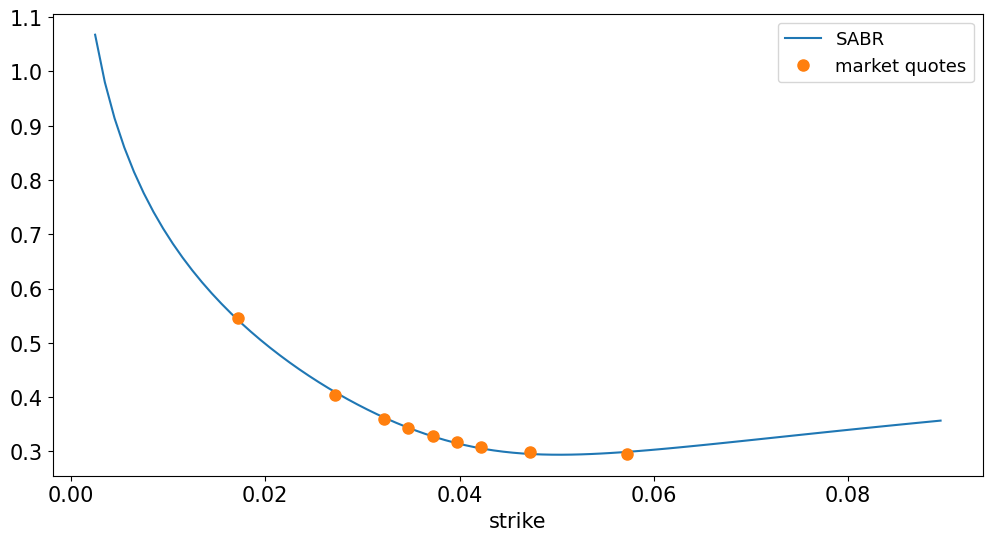

In [91]:
#Calculate implied volatility for each strike using the SABR model
strikegrid = np.arange(.0025, .09, .0010) 
if doSLIM:
    ivolgrid = sabr_slim(BETA, nustar, rhostar, F, strikegrid, Topt, volATM)  
else:
    ivolgrid = sabr(BETA, nustar, rhostar, alphastar, F, strikegrid, Topt)  

sabrcurve = pd.DataFrame(ivolgrid, index=strikegrid, columns=['SABR'])
volquotes = vols.copy()
volquotes.loc['strike'] = strikes
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol': 'market quotes'})

# Plot the SABR curve and market quotes
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
volquotes.plot(linestyle='', marker='o', markersize=8, ax=ax)
plt.legend();

The SABR model provides a good fit to market quotes, capturing the implied volatility skew and smile across different strikes. Since the SABR model's curve exactly matches the market quotes at all points, it achieves a perfect fit for those data points. 

## 1.3
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)



In [92]:
NEWSTRIKE = .05 
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap) + 1
freqcurve = 4
isPayer = True
step = round(freqcurve / freqswap)
discount = curves['discounts'].iloc[period_fwd + step : period_swap : step].sum() / freqswap

# Calculate the volatility for the new strike using the SABR model
if doSLIM:
    newvol = sabr_slim(BETA, nustar, rhostar, F, NEWSTRIKE, Topt, volATM)
else:
    newvol = sabr(BETA, nustar, rhostar, alphastar, F, NEWSTRIKE, Topt)

# Calculate the price of the swaption using Black's formula
newprice = N * blacks_formula(Topt, newvol, NEWSTRIKE, fwdswap, discount, isCall=isPayer)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.3624.'

## 1.4

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.
$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.

In [93]:
doSLIM = True 
if doSLIM:
    alphastar = solve_alpha(BETA, nustar, rhostar, Topt, volATM, F)  
    ivolSABR = sabr_slim(BETA, nustar, rhostar, F, strikes, Topt, volATM)  
else:
    alphastar = xstar[2]  
    ivolSABR = sabr(BETA, nustar, rhostar, alphastar, F, strikes, Topt)  

error = optim.fun
param = pd.DataFrame([BETA, alphastar, nustar, rhostar, error], index=['beta ($\\beta$)', 'alpha ($\\alpha$)', 'nu ($\\nu$)', 'rho ($\\rho$)', 'fit error'], columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.7500
alpha ($\alpha$),0.1417
nu ($\nu$),0.7930
rho ($\rho$),-0.4282
fit error,0.0001


***

# 2. SABR and Risk Management

Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens on `Feb 21, 2024`.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.

## 2.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate increased `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)

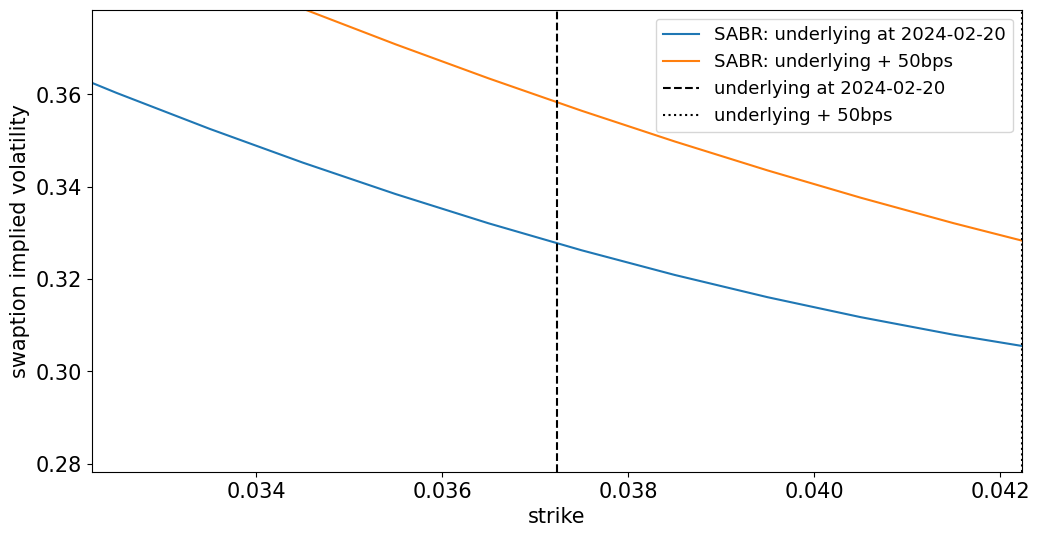

In [94]:
import warnings
warnings.filterwarnings('ignore') 

SHIFT = 50 / 100 / 100  

sabrcurve.rename(columns={'SABR': f'SABR: underlying at {DATE}'}, inplace=True)

# Calculate new SABR volatilities with the underlying rate increased by 50bps
if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr_slim(BETA, nustar, rhostar, F + SHIFT, strikegrid, Topt, volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA, nustar, rhostar, alphastar, F + SHIFT, strikegrid, Topt)

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
plt.xlim([F - .005, F + .005])  # Focus on a narrow range around the forward rate
plt.ylim([volATM - .05, volATM + .05])  
plt.axvline(F, color='k', linestyle='--', label=f'underlying at {DATE}')
plt.axvline(F + SHIFT, color='k', linestyle=':', label=f'underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('swaption implied volatility')
plt.xlabel('strike')
plt.legend()


## 2.2

Now, we consider how the volatility may change with the underlying shift of `50bps`.

Using the same SABR parameters from `1.1`, and the strike grid from `1.2`, plot the new SABR curve accounting for the underlying rate shifting up `50bps`.

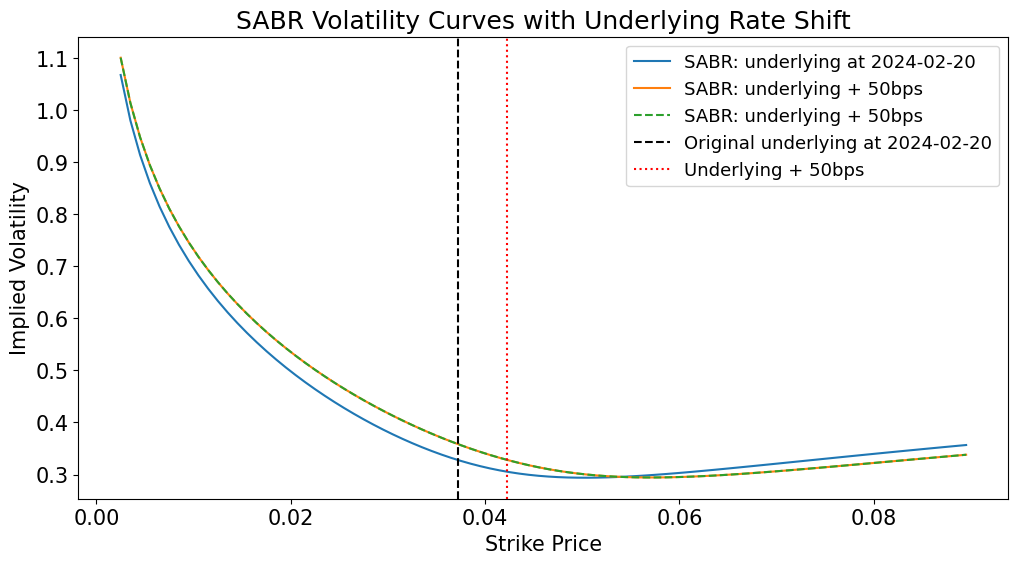

In [95]:
if doSLIM:
    # For the SLIM SABR model, calculate implied volatilities after increasing the forward rate by 50bps
    new_sabr_vol = sabr_slim(BETA, nustar, rhostar, F + SHIFT, strikegrid, Topt, volATM)
else:
    # For the standard SABR model, do the same calculation
    new_sabr_vol = sabr(BETA, nustar, rhostar, alphastar, F + SHIFT, strikegrid, Topt)

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax, title="SABR Volatility Curves with Underlying Rate Shift")
plt.plot(strikegrid, new_sabr_vol, label=f'SABR: underlying + {SHIFT*100*100:.0f}bps', linestyle='--')
plt.axvline(F, color='k', linestyle='--', label=f'Original underlying at {DATE}')
plt.axvline(F + SHIFT, color='r', linestyle=':', label=f'Underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('Implied Volatility')
plt.xlabel('Strike Price')
plt.legend()
plt.show()


## 2.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `2.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`

In [96]:
idloc = (sabrcurve.index.to_series() - fwdswap).abs().idxmin()

newvols = sabrcurve.loc[idloc]
strikeATM = strikes[idstrikeATM]  

Frange = F + [0, SHIFT]  # Define the range of forward rates including the shift

In [97]:
# Locate the periods for the forward and swap rates within the 'curves' dataset
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap) + 1
step = round(freqcurve / freqswap)

# Calculate the discount factor for the swaption
discount = curves['discounts'].iloc[period_fwd + step : period_swap : step].sum() / freqswap

# Calculate swaption prices using Black's formula for both static and dynamic scenarios
blackprices = pd.Series(N * blacks_formula(Topt - np.array([0, 1/365]), newvols[0], strikeATM, Frange, discount, isCall=isPayer), index=[DATE, 'shift'], name='static').to_frame().T
blackprices.loc['dynamic'] = N * blacks_formula(Topt - np.array([0, 1/365]), newvols, strikeATM, Frange, discount, isCall=isPayer)
blackprices.style.format('{:.2f}')

,2024-02-20,shift
static,1.68,2.79
dynamic,1.68,2.94


## 2.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `2.1`?

In [98]:
delta = (blackprices.diff(axis=1) / SHIFT)['shift'].rename('delta') 
delta.to_frame().style.format('{:.2f}')  

delta_relative_change = delta.pct_change().loc['dynamic']  #
display(f'Relative change to delta: {delta_relative_change:.2%}.')

'Relative change to delta: 13.75%.'

***